### 📊 Descripción de los datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow as pa
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

/home/hfo/Documents/Personal/blacksmith/00_initial_process/predict_energy_consumption/venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


#### 💾 Carga de Data Set

In [2]:
train_df = pd.read_parquet('../data/processed/train_dataset.parquet', engine='pyarrow')
train_df.sort_values(by="Fecha HR", inplace=True)
test_df  = pd.read_parquet('../data/processed/test_dataset.parquet', engine='pyarrow')
test_df.sort_values(by="Fecha HR", inplace=True)

### 🤖 Creacion y test de modelo

Dado que se observan comportamientos diferentes entre clientes, se generaran series temporales por cada cliente, para esto es necesario dividir dadaset, por dataset para cada cliente

##### ✂️ Dividimos dataset de entrenamiento por cada cliente

In [4]:
# Crear un diccionario para almacenar los datos por cliente
train_data_by_client = {}

# Obtener los clientes únicos
clients = train_df['CLIENTE'].unique()

# Iterar sobre cada cliente y almacenar los datos correspondientes en el diccionario
for client in clients:
    train_data_by_client[client] = train_df[train_df['CLIENTE'] == client].reset_index(drop=True)
    train_data_by_client[client] = train_data_by_client[client].drop('CLIENTE', axis=1)

# Verificar los datos por cliente
for client, data in train_data_by_client.items():
    print(f"Cliente: {client}, Número de registros: {data.shape[0]}")

Cliente: C-2, Número de registros: 90948
Cliente: C-4, Número de registros: 90948
Cliente: C-3, Número de registros: 90948
Cliente: C-5, Número de registros: 90948
Cliente: C-R, Número de registros: 91235


##### 🕺🤖 Generacion de 1 modelo por cada cliente

In [6]:
# Ajustar modelos Prophet para cada cliente
modelos_prophet = {}
for client, data in train_data_by_client.items():
    # Renombrar las columnas de datos para que coincidan con las convenciones de Prophet
    pjme_train_prophet = data.rename(columns={'Fecha HR': 'ds', 'kWh E': 'y'})


    # Crear y ajustar el modelo Prophet para el cliente actual
    model = Prophet()
    model.fit(pjme_train_prophet)
    
    # Almacenar el modelo ajustado en el diccionario de modelos
    modelos_prophet[client] = model

13:13:57 - cmdstanpy - INFO - Chain [1] start processing
13:14:10 - cmdstanpy - INFO - Chain [1] done processing
13:14:18 - cmdstanpy - INFO - Chain [1] start processing
13:16:21 - cmdstanpy - INFO - Chain [1] done processing
13:16:29 - cmdstanpy - INFO - Chain [1] start processing
13:16:41 - cmdstanpy - INFO - Chain [1] done processing
13:16:48 - cmdstanpy - INFO - Chain [1] start processing
13:17:19 - cmdstanpy - INFO - Chain [1] done processing
13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:20:18 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
modelos_prophet

{'C-2': <prophet.forecaster.Prophet at 0x7fc6576f8ec0>,
 'C-4': <prophet.forecaster.Prophet at 0x7fc65774cb00>,
 'C-3': <prophet.forecaster.Prophet at 0x7fc656772f60>,
 'C-5': <prophet.forecaster.Prophet at 0x7fc6577a0200>,
 'C-R': <prophet.forecaster.Prophet at 0x7fc658c69130>}

##### ✂️ Dividimos dataset de test por cada cliente

In [7]:
# Crear un diccionario para almacenar los datos por cliente
test_data_by_client = {}

# Obtener los clientes únicos
clients_test = test_df['CLIENTE'].unique()

# Iterar sobre cada cliente y almacenar los datos correspondientes en el diccionario
for client in clients_test:
    test_data_by_client[client] = test_df[test_df['CLIENTE'] == client].reset_index(drop=True)
    test_data_by_client[client] = test_data_by_client[client].drop('CLIENTE', axis=1)

# Verificar los datos por cliente
for client, data in test_data_by_client.items():
    print(f"Cliente: {client}, Número de registros: {data.shape[0]}")

Cliente: C-2, Número de registros: 22812
Cliente: C-3, Número de registros: 22812
Cliente: C-4, Número de registros: 22812
Cliente: C-5, Número de registros: 22812
Cliente: C-R, Número de registros: 22812


##### 🛠️ Test modelo

In [17]:
# Ajustar modelos Prophet para cada cliente
predict_prophet = {}
for client, data in test_data_by_client.items():
    pjme_test_prophet = data.reset_index().rename(columns={'Fecha HR':'ds','kWh E':'y'})
    
    model = modelos_prophet[client]
    pjme_test_fcst = model.predict(pjme_test_prophet)
    
    # Almacenar datos predichos
    predict_prophet[client] = pjme_test_fcst

In [19]:
for client, data in test_data_by_client.items():
    MSE = np.sqrt(mean_squared_error(y_true=data['kWh E'],
                y_pred=predict_prophet[client]['yhat']))
    MAE = mean_absolute_error(y_true=data['kWh E'],
                y_pred=predict_prophet[client]['yhat'])
    MAPE = mean_absolute_percentage_error(y_true=data['kWh E'],
                y_pred=predict_prophet[client]['yhat'])
    
    print('Cliente: ' + client)
    print('MSE: ' + str(MSE))
    print('MAE: ' + str(MAE))
    print('MAPE: ' + str(MAPE))

Cliente: C-2
MSE: 24.940945096043087
MAE: 18.394020212458155
MAPE: 0.06090211349331913
Cliente: C-3
MSE: 51.58964887958863
MAE: 36.09446199874043
MAPE: 0.18837102387019392
Cliente: C-4
MSE: 33.563521090268914
MAE: 22.249073315681326
MAPE: 0.2764941592703327
Cliente: C-5
MSE: 51.37698381625541
MAE: 38.917797481387886
MAPE: 0.31852621179166024
Cliente: C-R
MSE: 131.3982245881861
MAE: 125.4989110426322
MAPE: 0.38010727605920797



________

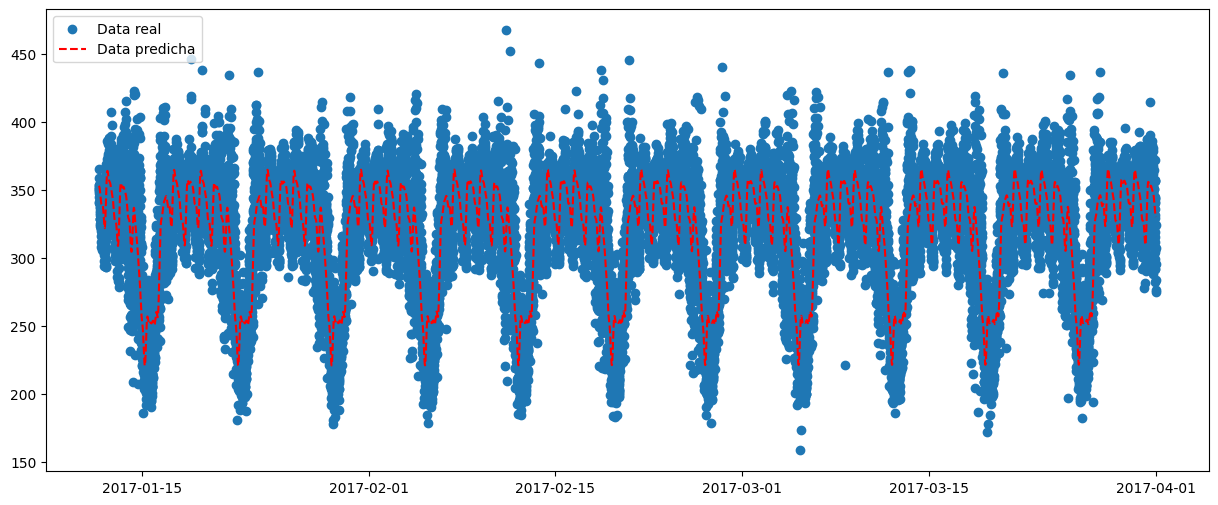

In [29]:
plt.figure(figsize=(15, 6))
plt.scatter(test_data_by_client['C-2']['Fecha HR'], test_data_by_client['C-2']['kWh E'], label='Data real')
plt.plot(predict_prophet['C-2']['ds'], predict_prophet['C-2']['yhat'], linestyle='--', color='red', label='Data predicha')
plt.legend(loc='upper left')
plt.show()

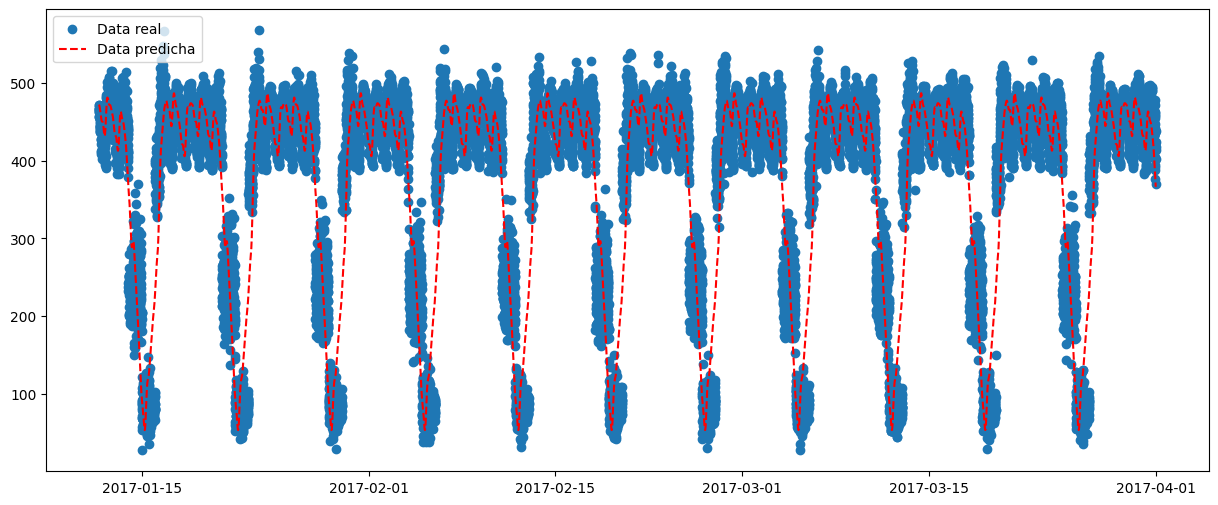

In [30]:
plt.figure(figsize=(15, 6))
plt.scatter(test_data_by_client['C-3']['Fecha HR'], test_data_by_client['C-3']['kWh E'], label='Data real')
plt.plot(predict_prophet['C-3']['ds'], predict_prophet['C-3']['yhat'], linestyle='--', color='red', label='Data predicha')
plt.legend(loc='upper left')
plt.show()

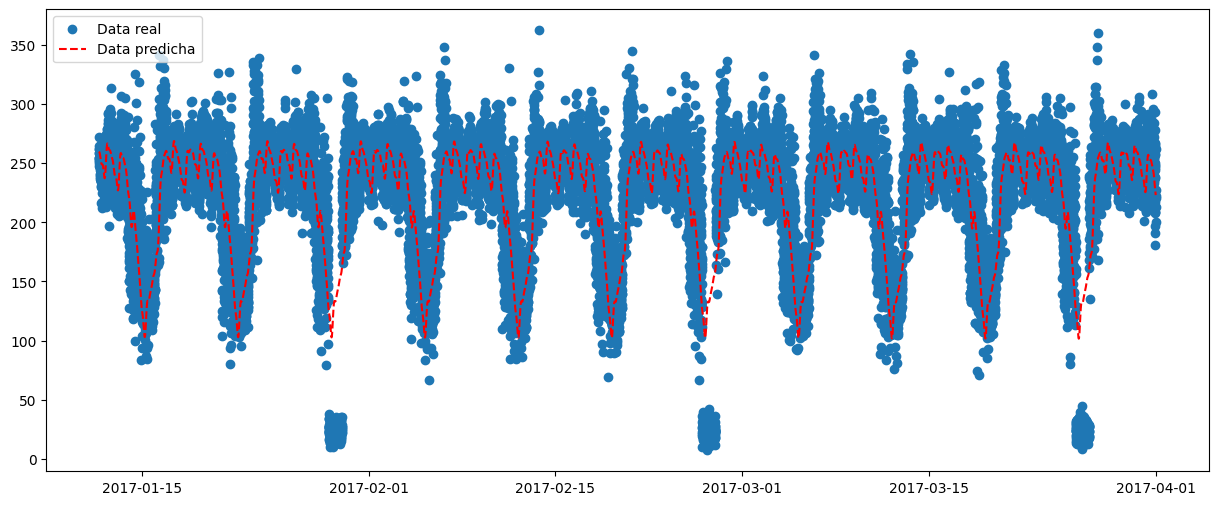

In [31]:
plt.figure(figsize=(15, 6))
plt.scatter(test_data_by_client['C-4']['Fecha HR'], test_data_by_client['C-4']['kWh E'], label='Data real')
plt.plot(predict_prophet['C-4']['ds'], predict_prophet['C-4']['yhat'], linestyle='--', color='red', label='Data predicha')
plt.legend(loc='upper left')
plt.show()

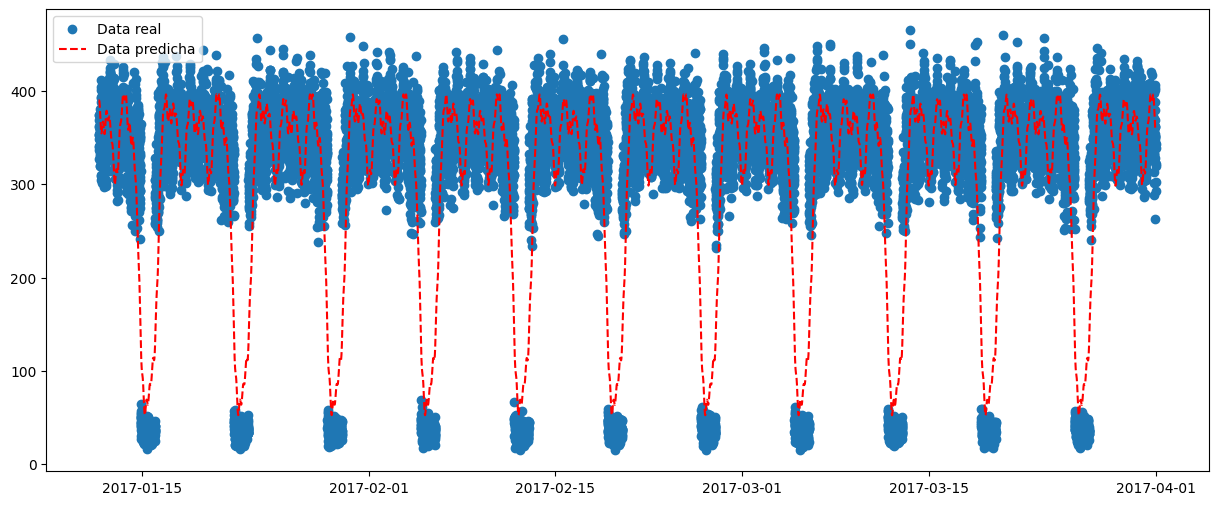

In [32]:
plt.figure(figsize=(15, 6))
plt.scatter(test_data_by_client['C-5']['Fecha HR'], test_data_by_client['C-5']['kWh E'], label='Data real')
plt.plot(predict_prophet['C-5']['ds'], predict_prophet['C-5']['yhat'], linestyle='--', color='red', label='Data predicha')
plt.legend(loc='upper left')
plt.show()

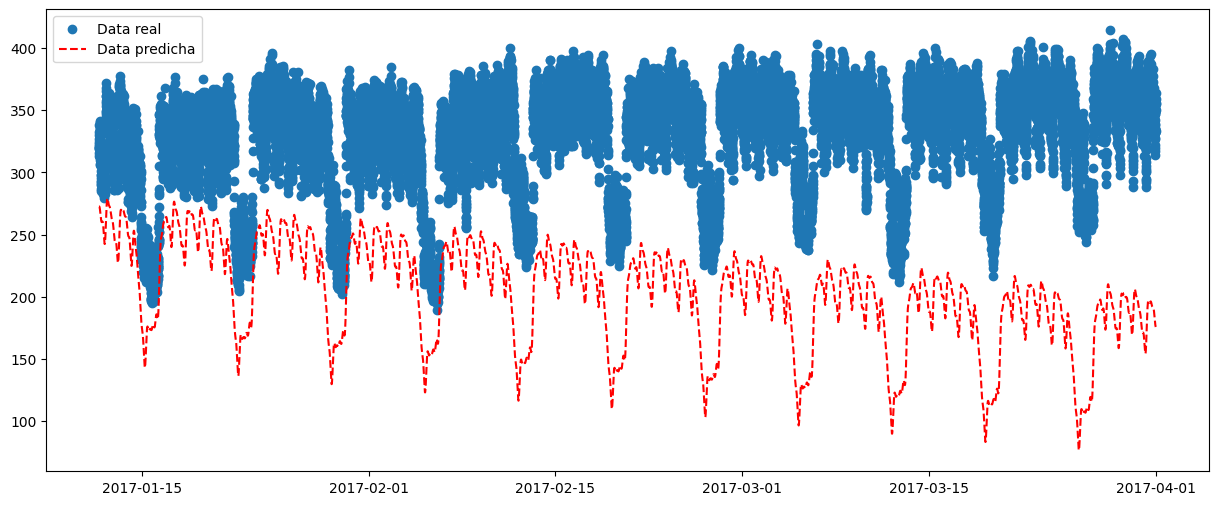

In [33]:
plt.figure(figsize=(15, 6))
plt.scatter(test_data_by_client['C-R']['Fecha HR'], test_data_by_client['C-R']['kWh E'], label='Data real')
plt.plot(predict_prophet['C-R']['ds'], predict_prophet['C-R']['yhat'], linestyle='--', color='red', label='Data predicha')
plt.legend(loc='upper left')
plt.show()

----------------------

#### 💾 Carga Modelos

In [35]:
from joblib import dump

dump( modelos_prophet['C-2'], '../models/prophet_C2.joblib'  )
dump( modelos_prophet['C-3'], '../models/prophet_C3.joblib'  )
dump( modelos_prophet['C-4'], '../models/prophet_C4.joblib'  )
dump( modelos_prophet['C-5'], '../models/prophet_C5.joblib'  )
dump( modelos_prophet['C-R'], '../models/prophet_CR.joblib'  )

['../models/prophet_CR.joblib']